# React Prompting without similar Problems

In [1]:
import json
from functions import inference
from new_templates import *
from templates import *

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool

In [3]:
python_repl_tool = PythonREPLTool()

In [4]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    """Creating an agent"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [5]:
def agent_node(state, agent, name, log):
    result = agent.invoke(state)
    log[name] = result["output"]
    return {"messages": [HumanMessage(content=result['output'], name=name)]}

In [6]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Noter", "Validator", "Explainer"]
system_prompt = (
    "你是一名监督员，负责管理以下成员之间的对话：{members}。"
    "根据以下用户请求，指定下一个需要行动的成员。每个成员将执行一个任务,"
    "你的任务是安排Noter, Explainer, Validator之间的工作，让他们合作写出一个完美的题目解析"
    "Validator检查Noter的板书是否正确，如果不正确应该将正确答案返回给Noter让其根据正确答案重新生成符合要求的板书"
    "当Noter重新生成板书后，请将Noter的板书再次传递给Validator查验，只有当Validator的验证Noter板书的正确性后，转去Explainer"
    "每一步反馈他们的结果和状态。任务完成后，请回复“FINISH”。"
)

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "选择下一步由谁来执行",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "根据以上内容，下一步应该轮到谁了？"
            "或者我们是否已经得到不错的讲解，可以“完成”了呢？"
            "请从以下选项中选一个：{options}",
        )
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model='gpt-4o', max_tokens=1000)

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [7]:
import functools
import operator
from typing import Sequence, TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
log = {}

noter_agent = create_agent(llm, [python_repl_tool], noter_template)
noter_node = functools.partial(agent_node, agent=noter_agent, name="Noter", log=log)

explainer_agent = create_agent(llm, [python_repl_tool], explainer_react_template)
explainer_node = functools.partial(agent_node, agent=explainer_agent, name="Explainer", log=log)

validator_agent = create_agent(llm, [python_repl_tool], validator_correctness_template)
validator_node = functools.partial(agent_node, agent=validator_agent, name="Validator", log=log)

def supervisor_node(state, log):
    result = supervisor_chain.invoke(state)
    log["Supervisor"] = result
    return result

workflow = StateGraph(AgentState)
workflow.add_node("Noter", noter_node)
workflow.add_node("Explainer", explainer_node)
workflow.add_node("Validator", validator_node)
workflow.add_node("Supervisor", functools.partial(supervisor_node, log=log))

In [8]:
for member in members:
    workflow.add_edge(member, "Supervisor")

conditional_map = {k:k for k in members}
conditional_map['FINISH'] = END
workflow.add_conditional_edges("Supervisor", lambda x: x['next'], conditional_map)
workflow.add_edge(START, "Supervisor")

graph = workflow.compile()

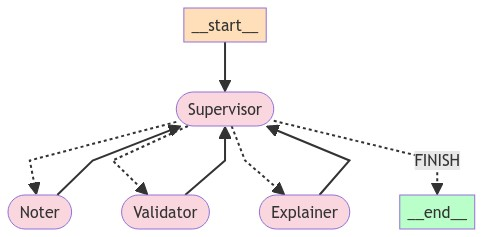

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [10]:
import json
with open("test_problem_set.json", 'r') as file:
    problem_set = json.load(file)
problems = []
answers = []
for i in range(len(problem_set)):
    problems.append(problem_set[i]['problem'])
    answers.append(problem_set[i]['answer'])

In [11]:
log = []
for i in range(100):
    record = []
    problem = "### 原题：" + problems[i]
    answer = "### 标准答案：" + answers[i]
    try:
        for s in graph.stream(
            {
                "messages": [
                    HumanMessage(content=problem),
                    HumanMessage(content=answer)
                ],
            },
            {"recursion_limit": 10},
        ):
            if "__end__" not in s:
                record.append(s)
                print(s)
                print("----")
        log.append(record)
    except Exception as e:
        log.append(["error", "error"])


{'Supervisor': {'next': 'Noter'}}
----
{'Noter': {'messages': [HumanMessage(content='知识点讲解:本题考查的知识点是数的分类，解题关键点是正确识别每个数属于哪个数集。\n\n### 板书一:\n(1) 整数集合:\n整数包括正整数、负整数和零，不包括小数和分数。\n依题意得：\n0\n-√9 = -3\n-10\n故整数集合为：{0, -3, -10}\n\n### 板书二:\n(2) 正实数集合:\n正实数包括所有大于零的有理数和无理数。\n依题意得：\nπ\n2.022\n故正实数集合为：{π, 2.022}\n\n### 板书三:\n(3) 无理数集合:\n无理数包括所有不能表示成两个整数之比的实数。\n依题意得：\nπ\n-1.1010010001...\n故无理数集合为：{π, -1.1010010001...}\n\n故答案是：\n(1) 整数集合：{0, -3, -10}\n(2) 正实数集合：{π, 2.022}\n(3) 无理数集合：{π, -1.1010010001...}', name='Noter')]}}
----
{'Supervisor': {'next': 'Validator'}}
----
{'Validator': {'messages': [HumanMessage(content='### 验证过程：\n\n1. **整数集合**：\n    - 整数包括正整数、负整数和零，不包括小数和分数。\n    - 检查每个数：\n        - -2.4：不是整数。\n        - π：不是整数。\n        - 2.022：不是整数。\n        - -10/3：不是整数。\n        - -0.15：不是整数。\n        - 0：整数。\n        - -√9 = -3：整数。\n        - -10：整数。\n        - -1.101 001 000 1⋯：不是整数。\n\n    故整数集合为：{0, -3, -10}\n\n2. **正实数集合**：\n    - 正实数包括所有大于零的有理数和无理数。\n    - 检查每个数：\n        - π：正实数。\n       

Python REPL can execute arbitrary code. Use with caution.


{'Noter': {'messages': [HumanMessage(content='知识点讲解:本题考查的知识点是新运算的定义及解不等式的能力，解题关键点是根据新运算的定义进行计算和正确解不等式。\n\n### 板书一:\n$3 ⊗ 4 = \\frac{1}{3} - \\frac{3-4}{3}$\n$= \\frac{1}{3} - \\frac{-1}{3}$\n$= \\frac{1}{3} + \\frac{1}{3}$\n$= \\frac{2}{3}$\n\n### 板书二:\n$2 ⊗ x = \\frac{1}{2} - \\frac{2-x}{2}$\n$\\frac{1}{2} - \\frac{2-x}{2} < 1$\n$1 - (2 - x) < 2$\n$1 - 2 + x < 2$\n$x < 3$\n$x$为非负整数\n故答案是 $x = 0, 1, 2$', name='Noter')]}}
----
{'Supervisor': {'next': 'Validator'}}
----
{'Validator': {'messages': [HumanMessage(content='### 验证过程：\n\n#### (1) 验证 3 ⊗ 4 的计算：\n\n根据定义，$a ⊗ b = \\frac{1}{a} - \\frac{a - b}{a}$。\n\n1. 代入 a = 3, b = 4：\n\\[ 3 ⊗ 4 = \\frac{1}{3} - \\frac{3 - 4}{3} \\]\n\n2. 计算 \\( \\frac{1}{3} \\) 和 \\( \\frac{3 - 4}{3} \\)：\n\\[ \\frac{3 - 4}{3} = \\frac{-1}{3} \\]\n\n3. 计算 \\( \\frac{1}{3} - \\frac{-1}{3} \\):\n\\[ \\frac{1}{3} - \\frac{-1}{3} = \\frac{1}{3} + \\frac{1}{3} = \\frac{2}{3} \\]\n\n验证结果：答案正确。\n\n#### (2) 验证不等式解答：\n\n根据定义，$a ⊗ b = \\frac{1}{a} - \\frac{a - b}{a}$。代入 

In [13]:
final_notes = []
final_expls = []
for i in range(len(log)):
    noter_log = []
    explainer_log = []
    # print(log[i])
    record = log[i]
    if record[0] == "error" and record[1] == "error":
        final_notes.append("Error")
        final_expls.append("Error")
        continue
    for item in record:
        for role in item:
            if role == "Supervisor" or role == "Validator": continue
            if role == "Noter":
                noter_log.append(item[role]['messages'][0].content)
            if role == "Explainer":
                explainer_log.append(item[role]['messages'][0].content)
    final_notes.append(noter_log[-1])
    final_expls.append(explainer_log[-1])

In [14]:
pbl_set = []
for i in range(len(final_notes)):
    cur = {}
    cur['problem'] = problems[i]
    cur['Note'] = final_notes[i]
    cur['Expl'] = final_expls[i]
    pbl_set.append(cur)

with open("outputs/model_2_ouptut.json", 'w', encoding='utf-8') as file:
    json.dump(pbl_set, file, ensure_ascii=False, indent=4)

In [24]:
print(final_expls[0])

同学们，今天我们来讲解如何把一些数填入对应的数集。我们需要把每个数归类到整数集合、正实数集合和无理数集合中。

### 讲解一：整数集合
首先，什么是整数？整数包括正整数、负整数和零。请思考一下，哪些数符合这些条件？

在给出的数中，有0，这是一个整数；还有-√9，虽然它看起来复杂，但我们知道√9等于3，所以-√9等于-3，这是一个负整数；另外还有-10，也是一个负整数。所以，整数集合包含：0, -√9（即-3）, -10。

### 讲解二：正实数集合
接下来，我们来看正实数集合。正实数是所有大于零的实数。请同学们思考一下，哪些数是大于零的？

在给出的数中，π（圆周率）是一个无理数，但它大于零；2.022是一个有理数并且大于零，所以它是正实数。因此，正实数集合包含：π, 2.022。

### 讲解三：无理数集合
最后，我们来看无理数集合。无理数是那些不能表示为两个整数之比的数，它们的小数部分是无限不循环的。请同学们思考一下，哪些数符合这个条件？

在给出的数中，π是一个典型的无理数；-1.1010010001… 这个数的小数部分是无限不循环的，所以它也是一个无理数。因此，无理数集合包含：π, -1.1010010001…。

总结一下：
1. 整数集合包含：0, -√9, -10；
2. 正实数集合包含：π, 2.022；
3. 无理数集合包含：π, -1.1010010001…。

希望通过这个讲解，同学们对数的分类有了更清晰的理解。


In [25]:
for problem in problems[:1]:
    cur_note = await inference({"problem": problem}, noter_template)
    react_expl = await inference({"note": cur_note}, explainer_react_template)

executing
请提供题目。executing
好的，同学们，今天我们来讲解一个复杂的数学概念或计算步骤。我们将一步一步地拆解这个过程，使大家能够更好地理解和掌握。

### 题目：求解二次方程 \(x^2 - 4x + 4 = 0\)

### 讲解一：分析题目：求解二次方程 \(x^2 - 4x + 4 = 0\)
   a. 这是我们的起始点，无前一步。
   b. 当前步骤是理解方程的基本结构，即二次方程。二次方程的标准形式是 \(ax^2 + bx + c = 0\)。
   c. 下一步是尝试将方程因式分解，以便找到方程的根。请同学们思考一下，如何将这个二次方程因式分解？

### 讲解二：因式分解：将方程 \(x^2 - 4x + 4 = 0\) 因式分解为 \((x - 2)^2 = 0\)
   a. 基于前一步的理解，我们知道需要将方程因式分解。
   b. 我们通过观察发现，方程 \(x^2 - 4x + 4\) 可以写成 \((x - 2)^2\)，这是因为 \((x - 2)(x - 2) = x^2 - 4x + 4\)。这个步骤的难点在于识别出方程可以写成平方的形式。
   c. 接下来，我们将通过解这个平方方程来找到x的值。那么接下来我们应该做什么？

### 讲解三：解平方方程：从 \((x - 2)^2 = 0\) 得到 \(x - 2 = 0\)
   a. 前一步我们得到了 \((x - 2)^2 = 0\)。
   b. 这一步通过开平方来求解x的值，注意这里的操作是将方程两边同时开平方，得到 \(x - 2 = 0\)。
   c. 我们已经将方程简化为一个简单的一次方程。请同学们思考一下，如何从这个一次方程中解出x的值？

### 讲解四：求解x的值：从 \(x - 2 = 0\) 得到 \(x = 2\)
   a. 前一步我们得到了 \(x - 2 = 0\)。
   b. 这一步通过加法将2移至等式右边，得到 \(x = 2\)。这个步骤的难点在于理解移项的过程。
   c. 我们已经解出了x的值，x = 2。想一想，这个结果在数学和实际问题中意味着什么？

通过这四个步骤，我们成功地求解了二次方程 \(x^2 - 4x + 4 = 0\)，得到了x的值为2。希望大家能够理解每一步的计算过程和逻辑关系。

In [4]:
from langchain_core.output_parsers import StrOutputParser
async def check(note1: str, note2: str) -> bool:
    llm = ChatOpenAI(model='gpt-4o')
    sys_prompt =    r"""
                        你是一个题解检查者，你负责检查两个题解的最终答案是否一致。注意：题解不需要一模一样，
                        只要保证最后每一问的答案都完全一致即可。
                        如果答案一致：请输出是。如果答案不一致：请输出否。请确保输出一个字，不要输出“是“与”否”意外的内容

                        题解1:
                        {note1}
                        
                        题解2:
                        {note2}
                    """
    prompt = ChatPromptTemplate.from_template(sys_prompt)
    parser = StrOutputParser()
    chain = prompt | llm | parser

    response = chain.invoke(input={"note1": note1, "note2": note2})
    return response

In [10]:
with open("output_with_answer.json", 'r') as file:
    data = json.load(file)

score = 0
is_same = [0 for _ in range(len(data))]
for i in range(len(data)):
    print(f"----- processing {i} -----")
    response = await check(data[i]['Note'], answers[i])
    if response == "是":
        score += 1
        is_same[i] = 1

score /= len(data)
score

----- processing 0 -----
----- processing 1 -----
----- processing 2 -----
----- processing 3 -----
----- processing 4 -----
----- processing 5 -----
----- processing 6 -----
----- processing 7 -----
----- processing 8 -----
----- processing 9 -----
----- processing 10 -----
----- processing 11 -----
----- processing 12 -----
----- processing 13 -----
----- processing 14 -----
----- processing 15 -----
----- processing 16 -----
----- processing 17 -----
----- processing 18 -----
----- processing 19 -----
----- processing 20 -----
----- processing 21 -----
----- processing 22 -----
----- processing 23 -----
----- processing 24 -----
----- processing 25 -----
----- processing 26 -----
----- processing 27 -----
----- processing 28 -----
----- processing 29 -----
----- processing 30 -----
----- processing 31 -----
----- processing 32 -----
----- processing 33 -----
----- processing 34 -----
----- processing 35 -----
----- processing 36 -----
----- processing 37 -----
----- processing 38 --

0.9

In [13]:
for i in range(len(is_same)):
    if is_same[i] == 0: print(i)
    

5
8
13
16
35
41
65
76
81
99


In [20]:
import json
with open("output_with_answer.json", 'r') as file:
    data = json.load(file)

In [28]:
problems[35]

'若方程\\(3x^m + 2y^n = 4\\)是关于\\(x, y\\)的二元一次方程，那么\\(m = \\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_ , n = \\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\)。'

In [30]:
answers[35]

'\\(m = \\frac{1}{3} , n = 1\\)'

In [31]:
data[35]

{'problem': '若方程\\(3x^m + 2y^n = 4\\)是关于\\(x, y\\)的二元一次方程，那么\\(m = \\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_ , n = \\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\)。',
 'Note': '知识点讲解:本题考查的知识点是二元一次方程，解题关键点是理解方程的阶数和系数。\n\n### 板书一:\n\n若方程\\(3x^m + 2y^n = 4\\)是关于\\(x, y\\)的二元一次方程\n\n根据二元一次方程定义，方程中每个变量的指数都应该是1\n\n所以有:\n\\[m = 1\\]\n\\[n = 1\\]\n\n根据题意，方程是关于\\(x, y\\)的二元一次方程\n\n所以：\n\\[m = 1\\]\n\\[n = 1\\]\n\n### 板书二:\n\n因此:\n\\[m = 1\\]\n\\[n = 1\\]\n\n故答案是\\(m = 1 , n = 1\\)。',
 'Expl': '我们来详细讲解一下这个题目。\n\n### 讲解一：分析方程 \\(3x^m + 2y^n = 4\\)\na. 这是我们的起始点，无前一步。\nb. 首先，我们需要理解什么是二元一次方程。二元一次方程是指方程中含有两个变量，并且每个变量的指数都是1的方程。\nc. 接下来我们需要考虑如何根据这个定义来确定 \\(m\\) 和 \\(n\\) 的值。\n\n### 讲解二：确定 \\(m\\) 和 \\(n\\) 的值\na. 在前一步，我们了解到了二元一次方程的定义：每个变量的指数都应该是1。\nb. 因此，对于方程 \\(3x^m + 2y^n = 4\\) 来说，为了使其成为二元一次方程，\\(x\\) 和 \\(y\\) 的指数必须是1，即 \\(m = 1\\) 和 \\(n = 1\\)。\nc. 既然我们确定了 \\(m\\) 和 \\(n\\) 的值，下一步就是验证这个方程是否满足二元一次方程的标准。\n\n### 讲解三：验证结果\na. 前一步我们得到了 \\(m = 1\\) 和 \\(n = 1\\)。\nb. 将 \\(m\\) 和 \\(n\\) 的值代入原方程，我们得到 \\(3x + 2y = 4\\)。这个方程